In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload the file here

import pandas as pd
import io

# Automatically detect the uploaded filename
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Loaded: {filename}")
print(df.columns.tolist())
print(df.head())

Saving Life Expectancy Data.csv to Life Expectancy Data.csv
Loaded: Life Expectancy Data.csv
['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.

In [4]:
# Handle missing values
df = df.dropna()
print("Shape after dropping missing values:", df.shape)

# Encode 'Status' column
le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])  # Developed=0, Developing=1

Shape after dropping missing values: (1649, 22)


Skewness: -0.628758


<Axes: >

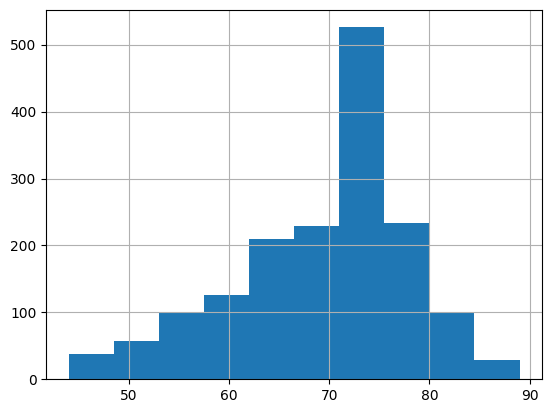

In [5]:
print("Skewness: %f" % df['Life expectancy '].skew())
df['Life expectancy '].hist()

<Axes: ylabel='count'>

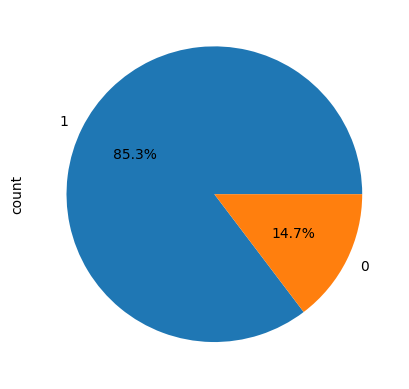

In [6]:
df['Status'].value_counts().plot.pie(autopct='%1.1f%%')

In [7]:
# Drop 'Country' column (non-numeric and not useful for regression)
df = df.drop(columns=['Country'])


In [8]:
# Feature Scaling (before splitting for better distribution)
X = df.drop(columns=['Life expectancy '])
y = df['Life expectancy ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<Axes: >

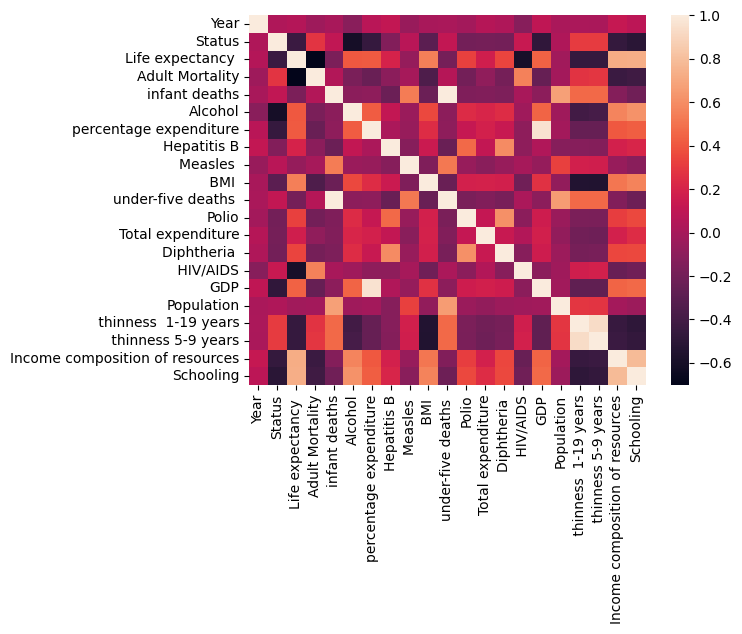

In [9]:
numeric_data = df.select_dtypes(include=[np.number])
corr = numeric_data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

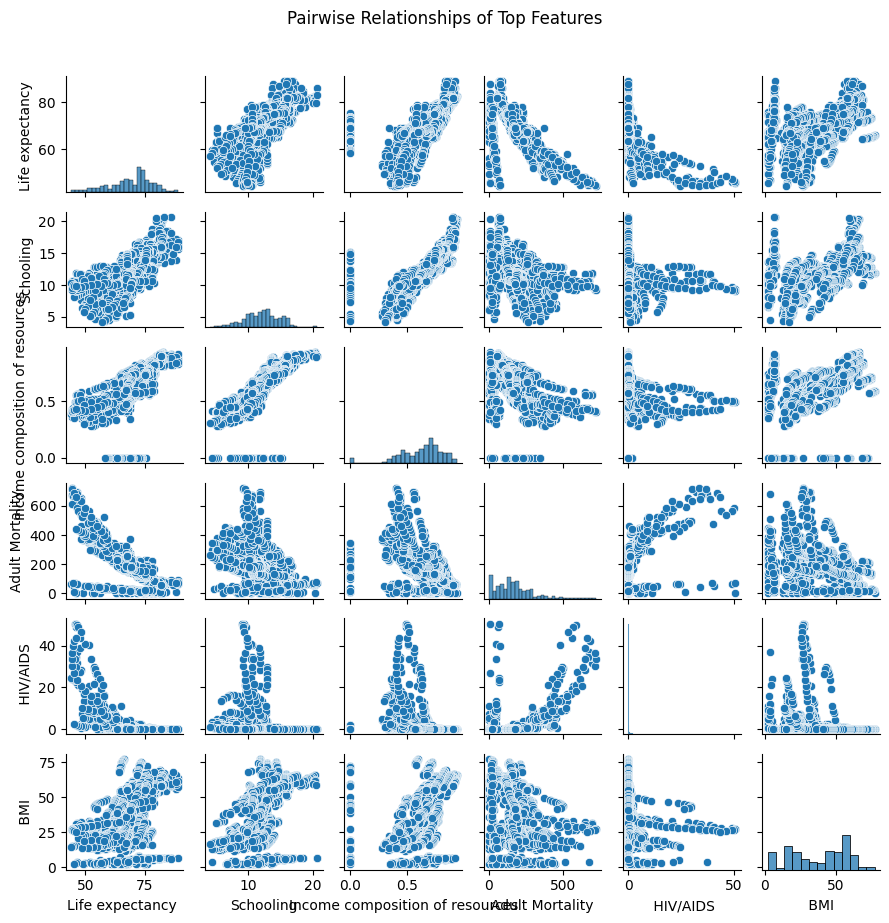

In [10]:
top_features = df.corr(numeric_only=True)['Life expectancy '].abs().sort_values(ascending=False).head(6).index.tolist()

sns.pairplot(df[top_features], height=1.5)
plt.suptitle("Pairwise Relationships of Top Features", y=1.02)
plt.tight_layout()
plt.show()


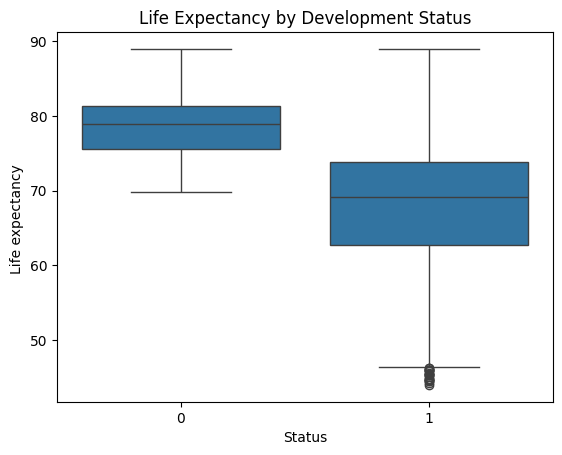

In [11]:
sns.boxplot(data=df, x='Status', y='Life expectancy ')
plt.title('Life Expectancy by Development Status')
plt.show()


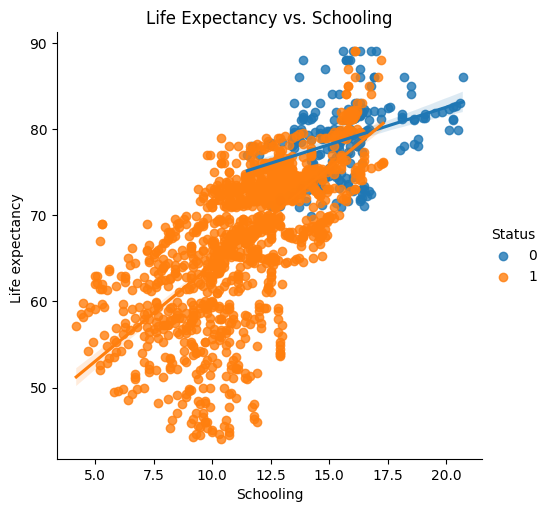

In [12]:
sns.lmplot(data=df, x='Schooling', y='Life expectancy ', hue='Status')
plt.title('Life Expectancy vs. Schooling')
plt.show()


In [13]:
df_train, df_test= train_test_split(df, test_size=0.2, random_state=42)

In [14]:
def outlier_threshhold(dataframe, column, q1=0.25, q3=0.75):
    Q1 = dataframe[column].quantile(q1)
    Q3 = dataframe[column].quantile(q3)
    iqr = Q3 - Q1
    up_limit = Q3 + 1.5 * iqr
    low_limit = Q1 - 1.5 * iqr
    return low_limit, up_limit

# Outlier Percentage
def outlier_percentage(dataframe, column):
    low_limit, up_limit = outlier_threshhold(dataframe, column)
    outliers = [x for x in dataframe[column] if (x > up_limit) | (x < low_limit)]
    print(column)
    print(f"Outliers percentage: {len(outliers) / (dataframe[column].shape[0]) * 100:.2f}%")
    print("--------------------")

# Checking Outliers
def check_outliers(dataframe, column):
    low_limit, up_limit = outlier_threshhold(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.impute import SimpleImputer

# Impute missing values with mean (you can also try 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='mean')

# Fit and transform the training data, transform the test data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [17]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42)
}

In [18]:
# Train and evaluate models
print("\nModel Performance:\n------------------")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:\n\tMSE: {mse:.2f}\n\tRMSE: {rmse:.2f}\n\tMAE: {mae:.2f}\n\tR² Score: {r2:.4f}")



Model Performance:
------------------
Linear Regression:
	MSE: 13.01
	RMSE: 3.61
	MAE: 2.75
	R² Score: 0.8167
Decision Tree:
	MSE: 8.95
	RMSE: 2.99
	MAE: 1.73
	R² Score: 0.8740
Random Forest:
	MSE: 3.65
	RMSE: 1.91
	MAE: 1.13
	R² Score: 0.9486
AdaBoost:
	MSE: 8.78
	RMSE: 2.96
	MAE: 2.39
	R² Score: 0.8763
XGBoost:
	MSE: 4.47
	RMSE: 2.12
	MAE: 1.24
	R² Score: 0.9370
Extra Trees:
	MSE: 2.72
	RMSE: 1.65
	MAE: 0.89
	R² Score: 0.9617


In [ ]:
# Get feature importances
rf_model = models['Random Forest']
importances = rf_model.feature_importances_

# Get feature names (assuming this matches X_train before transformation)
feature_names = df.drop(columns=['Life expectancy ']).columns

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort in ascending order
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Print
print(importance_df)


                            Feature  Importance
1                            Status    0.000138
6                       Hepatitis B    0.001951
12                      Diphtheria     0.002204
3                     infant deaths    0.002866
7                          Measles     0.003018
15                       Population    0.003051
10                            Polio    0.003116
9                under-five deaths     0.003229
5            percentage expenditure    0.003464
14                              GDP    0.003601
8                              BMI     0.004927
0                              Year    0.005360
4                           Alcohol    0.007818
17               thinness 5-9 years    0.008812
19                        Schooling    0.009378
11                Total expenditure    0.009429
16             thinness  1-19 years    0.015199
2                   Adult Mortality    0.123530
13                         HIV/AIDS    0.182715
18  Income composition of resources    0

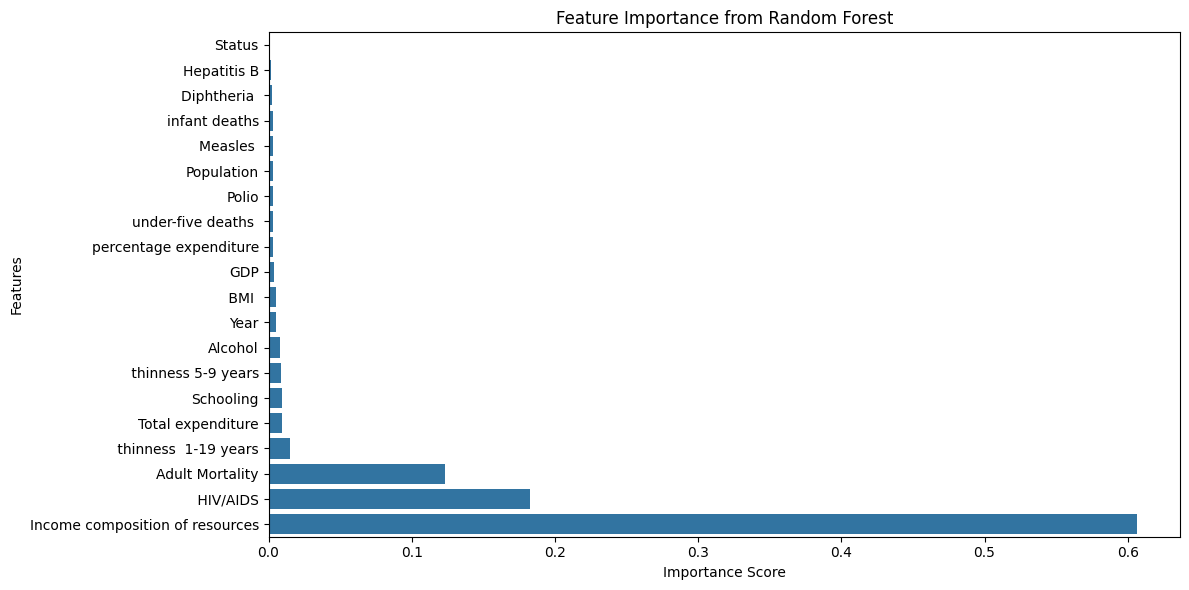

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

